# Using a Deep Q-Network on a multi-stock portfolio

## Retrieving Data

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.fundamentaldata import FundamentalData
import numpy as np
import yfinance as yf

In [27]:
key = 'L49TNJ1SKAPIG4BA'

### Function to retrieve data

In [30]:
def retrieve_data(tickr):
    ts = TimeSeries(key, output_format = 'pandas')
    data = yf.download(tickr)
    columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    data.columns = columns
    data = data.sort_index(ascending=True)
    data['Change Percentage'] = data['Close'].pct_change() * 100
    data['Force Index'] = data['Close'].diff() * data['Volume']
    
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    raw_money_flow = typical_price * data['Volume']
    money_flow_direction = typical_price.diff()
    positive_flow = raw_money_flow.where(money_flow_direction > 0, 0)
    negative_flow = raw_money_flow.where(money_flow_direction < 0, 0)
    positive_mf = positive_flow.rolling(window=14, min_periods=0).sum()
    negative_mf = negative_flow.rolling(window=14, min_periods=0).sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        money_ratio = positive_mf / negative_mf
        data['Money Flow Index'] = 100 - (100 / (1 + money_ratio))
        data['Money Flow Index'].replace([np.inf], 100, inplace=True)

    data['Price-Volume'] = (data['Close'].pct_change() * data['Volume']).cumsum()
    data['Standard Deviation'] = data['Close'].rolling(window=20).std()
    ti = TechIndicators(key, output_format = 'pandas')
    roc, meta = ti.get_roc(tickr)
    data['ROC'] = roc['ROC']
    return data

[*********************100%***********************]  1 of 1 completed
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_6951/573803762.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Money Flow Index'].replace([np.inf], 100, inplace=True)


                  Open        High         Low       Close     Volume  \
Date                                                                    
1980-12-12    0.098597    0.099025    0.098597    0.098597  469033600   
1980-12-15    0.093453    0.093881    0.093453    0.093881  175884800   
1980-12-16    0.086594    0.087022    0.086594    0.087022  105728000   
1980-12-17    0.088737    0.089165    0.088737    0.088737   86441600   
1980-12-18    0.091310    0.091738    0.091310    0.091310   73449600   
...                ...         ...         ...         ...        ...   
2025-07-07  209.949997  216.229996  208.800003  212.679993   50229000   
2025-07-08  210.009995  211.429993  208.449997  210.100006   42848900   
2025-07-09  211.139999  211.330002  207.220001  209.529999   48749400   
2025-07-10  212.410004  213.479996  210.029999  210.509995   44443600   
2025-07-11  211.160004  212.130005  209.860001  210.570007   39719300   

            Change Percentage   Force Index  Money

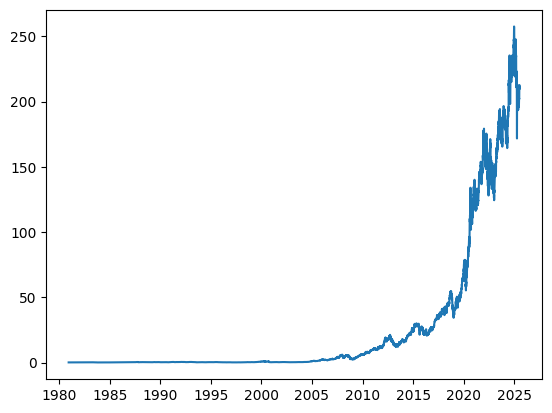

In [32]:
apple_data = retrieve_data('AAPL')
print(apple_data)
plt.plot(apple_data['Close'])

### Seperating test and train data

In [33]:
def split_data(data, start, end, test_start, test_end):
    train_data = data.loc[start : end]
    test_data = data.loc[test_start : test_end]
    return train_data, test_data

In [34]:
apple_train, apple_test = split_data(apple_data, '2012-02-01', '2022-04-06', '2022-04-07', '2025-01-01')

In [35]:
print(apple_train)

                  Open        High         Low       Close     Volume  \
Date                                                                    
2012-02-01   13.710421   13.794573   13.691187   13.777142  270046000   
2012-02-02   13.678263   13.739873   13.644001   13.701705  186796400   
2012-02-03   13.815306   13.824923   13.691483   13.743778  286599600   
2012-02-06   13.944243   13.974598   13.770832   13.776241  249412800   
2012-02-07   14.090307   14.117958   13.962576   13.982713  316223600   
...                ...         ...         ...         ...        ...   
2022-03-31  171.600815  174.961874  171.394427  174.775146  103049300   
2022-04-01  171.305969  171.866153  168.976818  171.030796   78751300   
2022-04-04  175.364792  175.413933  171.433727  171.561492   76468400   
2022-04-05  172.043060  175.227228  171.414090  174.441012   73401800   
2022-04-06  168.868713  170.637695  167.198014  169.389578   89058800   

            Change Percentage   Force Index  Money

Creating close price dataframe

In [36]:
def retrieve_close(train_data, test_data):
    train_close = train_data['Close']
    test_close = test_data['Close']
    return train_close, test_close

In [38]:
apple_train_close, apple_test_close = retrieve_close(apple_train, apple_test)

### Normalising data

In [39]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

def PCA_transform(train_data, test_data):
    # Scaling train data
    state_features = pd.DataFrame({
        'ROC': train_data['ROC'],
        'Volume': train_data['Volume'],
        'Change Percentage': train_data['Change Percentage'],
        'Force Index': train_data['Force Index'],
        'Money Flow Index': train_data['Money Flow Index'],
        'Price-Volume': train_data['Price-Volume'],
        'Standard Deviation': train_data['Standard Deviation']
    })
    scaler = MinMaxScaler() # Creating scaler object
    scaled_features_array = scaler.fit_transform(state_features)
    scaled_data = pd.DataFrame(scaled_features_array, columns=state_features.columns, index=state_features.index)

    # Train data PCA transform
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(scaled_data)

    # Scaling test data
    test_features = pd.DataFrame({
        'ROC': test_data['ROC'],
        'Volume': test_data['Volume'],
        'Change Percentage': test_data['Change Percentage'],
        'Force Index': test_data['Force Index'],
        'Money Flow Index': test_data['Money Flow Index'],
        'Price-Volume': test_data['Price-Volume'],
        'Standard Deviation': test_data['Standard Deviation']
    })
    scaled_test_features_array = scaler.transform(test_features) # Using ssame scaler object as train data
    scaled_test_data = pd.DataFrame(scaled_test_features_array, columns=test_features.columns)

    # PCA transform on test data
    X_test_pca = pca.transform(scaled_test_data)

    return X_train_pca, X_test_pca



In [40]:
apple_train_pca, apple_test_pca = PCA_transform(apple_train, apple_test)

## Creating Deep Q Network

### Setting up environment

In [44]:
class environment:

    def __init__(self, price_data, state_data):
        self.data = price_data
        self.scaled_state_data = state_data
        self.balance = 100
        self.holding = 0
        self.index = 0
        self.buy_price = None
        self.sell_price = None
        self.num_shares = 0
        self.trend = None
        self.balance_history = []
        self.price = None
        self.rewards = []
        self.total_reward = 0
        self.total = 100
        self.trades = []
        self.action_history = []

    def step(self, action):

        
        trade = [] 
        if self.index < len(self.data) - 7:
            data = self.data
            index = self.index
            old_net_worth = self.get_net_worth()
                
            
            total = self.get_net_worth()
            holding = (self.num_shares * data.iloc[self.index]) / total
            trade.append(total)
            trade.append(holding)
            trade.append(action)
            self.action_history.append(action)
            sold_bought = action - holding
            if action > holding:
                to_buy = (action - holding) * total
                new_balance = self.balance - to_buy
                if new_balance >= 0:
                    
                    new_shares = to_buy / self.data.iloc[self.index]
                    self.balance -= to_buy
                    self.num_shares += new_shares
            elif action < holding:
                to_sell = (holding - action) * total
                shares_to_sell = to_sell / data.iloc[self.index]
                new_num_shares = self.num_shares - shares_to_sell
                if new_num_shares >= 0:
                    self.num_shares = new_num_shares
                    self.balance += to_sell
            
            annual_rate = 0.054
            # Daily risk-free rate
            daily_rate = annual_rate / 365
            self.balance = self.balance * (1+ daily_rate)
            
            
                
           
                
            
            trade.append(self.num_shares)
            trade.append(self.balance)
            
            trade.append(self.data.iloc[self.index])
            self.index += 1
            
            new_net_worth = self.get_net_worth()
            self.balance_history.append(old_net_worth)

            # The reward is the change in value
            reward = new_net_worth - old_net_worth
            
            self.trades.append(trade)
            self.total_reward += reward
            self.rewards.append(self.total_reward)
            return (reward, False)
        else:
            return (0, True)
        
    def reset(self):
        self.balance = 100
        self.holding = 0
        self.index = 0
        self.buy_price = None
        self.sell_price = None
        self.num_shares = 0
        self.trend = None
        self.balance_history = []
        self.trades = []
    
    def get_net_worth(self):
        
        total = self.balance + (self.num_shares * self.data.iloc[self.index])
        return total
        
    def get_state(self):
        state = self.scaled_state_data[self.index].tolist()
        return state


### Training the model

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

# Create the Stock Environment
env = environment(apple_train_close, apple_train_pca)

# Neural network model for approximating Q-values
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update_freq = 1000
memory_size = 10000
episodes = 10
ACTIONS = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

# Initialize Q-networks
input_dim = 5
output_dim = 11
policy_net = DQN(input_dim, output_dim)
target_net = DQN(input_dim, output_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

# Function to choose action using epsilon-greedy policy
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, len(ACTIONS) - 1)  # Explore
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = policy_net(state)
        return torch.argmax(q_values).item()
        

# Function to optimize the model using experience replay
def optimize_model():
    if len(memory) < batch_size:
        return
    
    batch = random.sample(memory, batch_size)
    state_batch, action_batch, reward_batch, next_state_batch = zip(*batch)

    state_batch = torch.FloatTensor(state_batch)
 
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(next_state_batch)
    

    # Compute Q-values for current states
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Compute target Q-values using the target network
    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0]
        target_q_values = reward_batch + gamma * max_next_q_values

    loss = nn.MSELoss()(q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Main training loop
steps_done = 0

for episode in range(episodes):
    state = env.get_state()
    done = False
    i = 0
    for i in range(len(apple_train_pca) - 1):
        # Select action
        action_index = select_action(state, epsilon)
       
        action = ACTIONS[action_index]
        reward, done = env.step(action)
        
        next_state = env.get_state()
        # Store transition in memory
        memory.append((state, action_index, reward, next_state))
        
        # Update state
        state = next_state

        # Optimize model
        optimize_model()
        steps_done += 1

        # Update target network periodically
        if steps_done % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())


    # Decay epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    env.reset()
    #print(episode)

## Testing

In [49]:
def test(env):
    
    # Reset the environment
    env.reset()  
    state = env.get_state()
    step = 0
    done = False
    action_history = []
    sum = 0
    
    while env.index < (len(env.scaled_state_data) - 7):
       
     
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
            action_index = torch.argmax(q_values).item()
            
            action = ACTIONS[action_index]

        reward, done = env.step(action)
        sum += 1
        
        state = env.get_state()

        if done:
            break
   

In [51]:
test_env = environment(apple_test_close, apple_test_pca)
test(test_env)

### Assigning history values to dates

In [52]:
dates = pd.bdate_range(start='2022-04-07', periods=len(test_env.balance_history))
balances = pd.DataFrame({'Date': dates, 'Balance': test_env.balance_history})
balances.set_index('Date', inplace=True)
print(balances)

               Balance
Date                  
2022-04-07  100.000000
2022-04-08  100.327476
2022-04-11   98.715255
2022-04-12   98.353358
2022-04-13   98.061252
...                ...
2024-11-07  175.561886
2024-11-08  175.672880
2024-11-11  177.007941
2024-11-12  178.335579
2024-11-13  175.372089

[680 rows x 1 columns]


In [53]:
print((test_env.balance_history[-1] - test_env.balance_history[0]) / test_env.balance_history[0])

0.7537208863133102


### Plotting model performace against underlying stock price

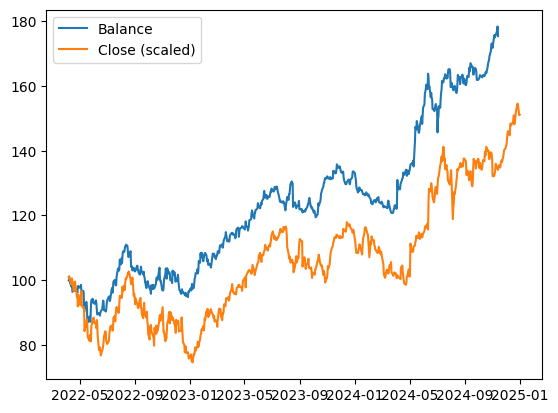

In [56]:
plt.plot(balances, label="Balance")
plt.plot(apple_test_close * 0.6, label="Close (scaled)")
plt.legend()
plt.show()